In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import pysal as ps
import geopandas as gpd
import libpysal as lps
import sys
import platform
import zipfile
import os
from datetime import datetime

import seaborn as sns
sns.set(style="darkgrid") # set style

print(sys.version_info)
print("Python Version: " + str(platform.python_version()))

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
Python Version: 3.7.3


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
# modeling packages
from  statsmodels.api import OLS
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from pysal.model import *
from pysal.explore.esda.moran import Moran
from scipy import stats
from pysal.lib.weights.weights import W

In [3]:
def analyze_preds_true(preds_y, true_y):
    """Code to analyze MSE, worst errors, plot residuals"""
    resids = preds_y - true_y
    print('Residual distribution:\n',stats.describe(resids))
    print('\nMSE:',mean_squared_error(true_y, preds_y))
    ## plot 1 is just pred vs true y
    sns.scatterplot(x=preds_y, y=true_y)
    plt.xlabel("Predictions")
    plt.ylabel("True")
    plt.title("Preds vs True")
    plt.show()
    ## plot 2 is redisuals
    sns.residplot(x=preds_y, y=resids,
                  lowess=True, 
                  scatter_kws={'alpha': 0.5}, 
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.title("Residual Plots")
    plt.show()

In [4]:
## create two train and test files, 
def create_train_test(data, cols, test_year, y_col):
    prev_year = test_year - 1
    X_train_all = data.query('year!=@test_year')[cols]
    y_train_all = data.query('year!=@test_year')[y_col]
    X_train_prevyear = data.query('year==@prev_year')[cols]
    y_train_prevyear = data.query('year==@prev_year')[y_col]
    
    X_test = data.query('year==@test_year')[cols]
    y_test = data.query('year==@test_year')[y_col]
    ## quick checks
    assert X_train_all.shape[0] == len(y_train_all) 
    assert X_train_prevyear.shape[0] == len(y_train_prevyear) 
    assert X_test.shape[0] == len(y_test) 
    assert X_train_all.shape[1] == len(cols) 
    print('There are %s training obs and %s test obs' % (len(y_train_all), len(y_test)))
    
    return(X_train_all, y_train_all, X_train_prevyear, y_train_prevyear, X_test, y_test)



## Modeling from Common Variables
Convert from weekly to yearly and start there.

In [5]:
malvika_url = "https://raw.githubusercontent.com/malvikarajeev/sfcrimeanalysis/master/weekly_crime_counts_with_varaibles.csv"
addtl_data = pd.read_csv(malvika_url, index_col=0)
addtl_data['GEOID'] = [str(g).rjust(11, '0') for g in addtl_data['GEOID']]
addtl_data.head(5)

,year,GEOID,week,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
1,2010,06075010100,1,34,4,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
2,2010,06075010100,2,29,9,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
3,2010,06075010100,3,21,6,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
4,2010,06075010100,4,21,15,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
5,2010,06075010100,5,22,6,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472


In [6]:
yearly_agg_data = addtl_data[['year','GEOID','N','N_calls_311']].groupby(['year','GEOID']).sum().reset_index()
yearly_agg_data.head(5)

,year,GEOID,N,N_calls_311
0,2010,06075010100,1604,600
1,2010,06075010200,823,634
2,2010,06075010300,234,445
3,2010,06075010400,289,599
4,2010,06075010500,1096,663


In [7]:
census_vars = addtl_data.drop(['week','N','N_calls_311'], axis=1).groupby(['year','GEOID']).mean().reset_index()
census_vars.head(5)

,year,GEOID,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
0,2010,06075010100,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472
1,2010,06075010200,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294
2,2010,06075010300,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169
3,2010,06075010400,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725
4,2010,06075010500,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299


In [8]:
yearly_data2 = yearly_agg_data.merge(census_vars, left_on=['year','GEOID'], right_on=['year','GEOID'], how='inner')
yearly_data2.head(5)

,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
0,2010,06075010100,1604,600,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472
1,2010,06075010200,823,634,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294
2,2010,06075010300,234,445,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169
3,2010,06075010400,289,599,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725
4,2010,06075010500,1096,663,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299


In [9]:
yearly_data2['rate'] = yearly_data2['N'] / yearly_data2['Estimate_Total']
yearly_data2['log_count'] = np.log(yearly_data2['N'])
yearly_data2['log_rate'] = np.log(yearly_data2['rate'])
yearly_data2.head(5)

,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class,rate,log_rate
0,2010,06075010100,1604,600,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472,0.428419,-0.847654
1,2010,06075010200,823,634,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294,0.196702,-1.626067
2,2010,06075010300,234,445,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169,0.054609,-2.907555
3,2010,06075010400,289,599,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725,0.069571,-2.665400
4,2010,06075010500,1096,663,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299,0.451214,-0.795812


In [10]:
x_cols = list(yearly_data2)[3:15]
print(x_cols)
X_train_all, y_train_all, X_train2016, y_train2016, X_test, y_test = create_train_test(yearly_data2,
                                                                                       cols=x_cols,
                                                                                       test_year=2017,
                                                                                      y_col='log_rate')

['N_calls_311', 'Estimate_Total', 'prop_rented', 'prop_male', 'prop_african_american', 'prop_under_poverty_level', 'prop_vacant_houses', 'prop_stable', 'racial_index', 'income_index', 'age_index', 'working_class']
There are 1365 training obs and 195 test obs


## Models using 2010-2016
1. RF
2. LR
3. Spatial LR

### Random Forest

Residual distribution:
 DescribeResult(nobs=195, minmax=(-1.778607513909466, 1.6250851308603398), mean=0.12836921544088012, variance=0.15935794217006347, skewness=-0.3261002003700649, kurtosis=3.2087129233430653)

MSE: 0.1750193774267138


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


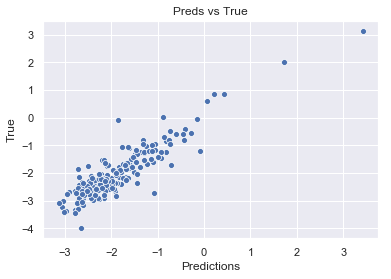

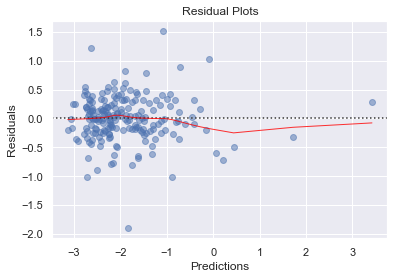

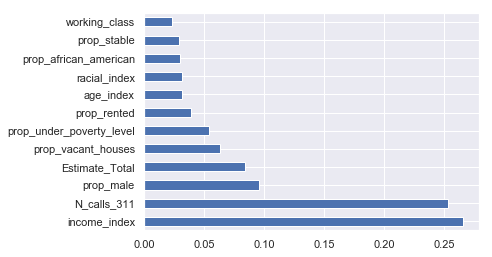

In [11]:
rf_tree = RandomForestRegressor(random_state=0)  
rf_tree.fit(X_train_all, y_train_all)  

y_pred_rf = rf_tree.predict(X_test)

analyze_preds_true(y_pred_rf, y_test)  # for model


feat_importances = pd.Series(rf_tree.feature_importances_, index=x_cols)
feat_importances.nlargest(12).plot(kind='barh')

### Linear Regression

In [12]:
lr_all = OLS(y_train_all,X_train_all).fit()
lr_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rate   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     1125.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:18:06   Log-Likelihood:                -1426.2
No. Observations:                1365   AIC:                             2876.
Df Residuals:                    1353   BIC:                             2939.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
N_calls_311                  0.0003   1.68e-05     17.930      0.000       0.000       0.000
Estimate_Total              -0.0003   5.58e-05     -4.663      0.000      -0.000      -0.000
prop_rented                  2.3230      1.108      2.096      0.036       0.149       4.497
prop_male                    2.4813      0.369      6.718      0.000       1.757       3.206
prop_african_american       -0.5692      0.205     -2.772      0.006      -0.972      -0.166
prop_under_poverty_level    -3.7033      0.386     -9.582      0.000      -4.461      -2.945
prop_vacant_houses          -0.0931      0.026     -3.633      0.000      -0.143      -0.043
prop_stable                  1.7431      0.302      5.772      0.000       1.151       2.336
racial_index                 0.0002   5.32e-05      3.055      0.002    5.82e-05       0.000
income_index                 0.0002   8.85e-05      2.184      0.029    1.97e-05       0.000
age_index                   -0.0002      0.000     -1.493      0.136      -0.000    6.62e-05
working_class               -0.6712      0.201     -3.347      0.001      -1.065      -0.278
==============================================================================
Omnibus:                      594.611   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9945.450
Skew:                           1.583   Prob(JB):                         0.00
Kurtosis:                      15.839   Cond. No.                     3.28e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.28e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Residual distribution:
 DescribeResult(nobs=195, minmax=(-3.6356569211044647, 3.078909175441933), mean=0.3244049680729634, variance=0.4394051645636624, skewness=-0.35780159653589877, kurtosis=8.877968057549946)

MSE: 0.5423903880558075


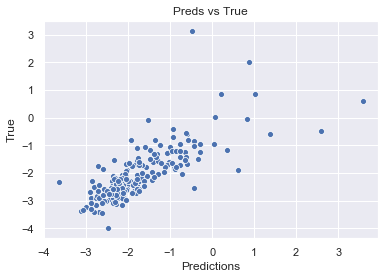

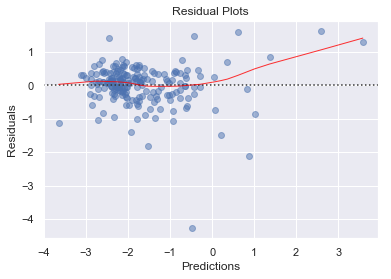

In [13]:
y_pred_lr = lr_all.predict(X_test)
analyze_preds_true(y_pred_lr, y_test)  # for model

Note, the errors have outliers and hint that this model, although low MSE, isn't fitting properly.

## Models with just 2016 to predict 2017

## RF

Residual distribution:
 DescribeResult(nobs=195, minmax=(-1.672570965300228, 0.9017151981581173), mean=0.06135535926101269, variance=0.1387044193300119, skewness=-0.8700020023404913, kurtosis=2.327332199617877)

MSE: 0.14175759472554691


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


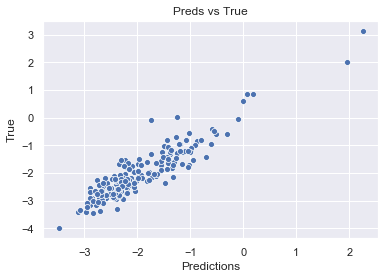

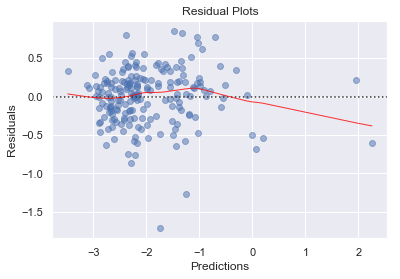

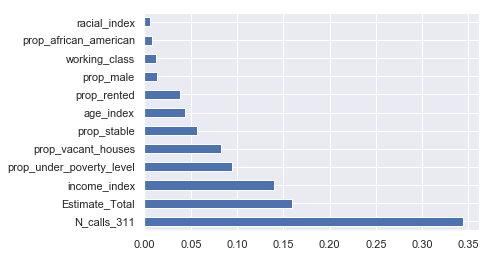

In [14]:
rf_tree = RandomForestRegressor(random_state=0)  
rf_tree.fit(X_train2016, y_train2016)  

y_pred_rf = rf_tree.predict(X_test)

analyze_preds_true(y_pred_rf, y_test)  # for model


feat_importances = pd.Series(rf_tree.feature_importances_, index=x_cols)
feat_importances.nlargest(12).plot(kind='barh')

## Linear Regression

In [15]:
lr2016 = OLS(y_train_all,X_train_all).fit()
lr2016.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rate   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     1125.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:18:07   Log-Likelihood:                -1426.2
No. Observations:                1365   AIC:                             2876.
Df Residuals:                    1353   BIC:                             2939.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
N_calls_311                  0.0003   1.68e-05     17.930      0.000       0.000       0.000
Estimate_Total              -0.0003   5.58e-05     -4.663      0.000      -0.000      -0.000
prop_rented                  2.3230      1.108      2.096      0.036       0.149       4.497
prop_male                    2.4813      0.369      6.718      0.000       1.757       3.206
prop_african_american       -0.5692      0.205     -2.772      0.006      -0.972      -0.166
prop_under_poverty_level    -3.7033      0.386     -9.582      0.000      -4.461      -2.945
prop_vacant_houses          -0.0931      0.026     -3.633      0.000      -0.143      -0.043
prop_stable                  1.7431      0.302      5.772      0.000       1.151       2.336
racial_index                 0.0002   5.32e-05      3.055      0.002    5.82e-05       0.000
income_index                 0.0002   8.85e-05      2.184      0.029    1.97e-05       0.000
age_index                   -0.0002      0.000     -1.493      0.136      -0.000    6.62e-05
working_class               -0.6712      0.201     -3.347      0.001      -1.065      -0.278
==============================================================================
Omnibus:                      594.611   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9945.450
Skew:                           1.583   Prob(JB):                         0.00
Kurtosis:                      15.839   Cond. No.                     3.28e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.28e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Residual distribution:
 DescribeResult(nobs=195, minmax=(-3.6356569211044647, 3.078909175441933), mean=0.3244049680729634, variance=0.4394051645636624, skewness=-0.35780159653589877, kurtosis=8.877968057549946)

MSE: 0.5423903880558075


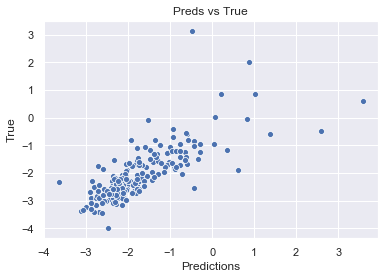

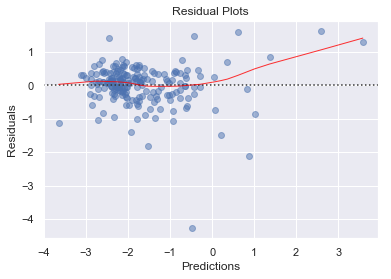

In [16]:
y_pred_lr = lr2016.predict(X_test)
analyze_preds_true(y_pred_lr, y_test)  # for model

### Linear Regression with Spatial

In [17]:
## shapefile load in
shapefile0 = gpd.read_file("tl_2010_06_tract10/tl_2010_06_tract10.shp")
shapefile = shapefile0.query("COUNTYFP10=='075' and ALAND10>0") # grab tracts with land 
shapefile.index = list(range(shapefile.shape[0])) # GEOID10 is match with R 
shapefile.head(5)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,+37.7741958,-122.4477884,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,06,075,016400,06075016400,164,Census Tract 164,G5020,S,309097,0,+37.7750995,-122.4369729,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,06,075,016300,06075016300,163,Census Tract 163,G5020,S,245867,0,+37.7760456,-122.4295509,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,06,075,016100,06075016100,161,Census Tract 161,G5020,S,368901,0,+37.7799831,-122.4286631,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,06,075,016000,06075016000,160,Census Tract 160,G5020,S,158236,0,+37.7823363,-122.4224838,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


In [18]:
spatial_census = pd.merge(shapefile, yearly_data2, left_on='GEOID10', right_on='GEOID', how='inner')
spatial_census.head(5)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,...,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class,rate,log_rate
0,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,...,0.860973,0.892645,0.312413,0.222361,396,2612.052450,931.67,0.500416,0.130923,-2.033148
1,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,...,0.883288,0.866613,0.274818,0.232052,331,2573.161577,894.45,0.487838,0.121420,-2.108498
2,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,...,0.873209,0.838458,0.222263,0.173248,516,2397.091988,881.33,0.496903,0.128726,-2.050067
3,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,...,0.883343,0.850349,0.202259,0.202307,446,2552.655480,906.67,0.471356,0.164681,-1.803742
4,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,...,0.850527,0.864932,0.223764,0.148609,1071,2915.401259,1019.72,0.487126,0.146881,-1.918133


#### Helper functions to create spatial data

In [19]:
def create_shp_year(data, year, location, fn):
    clean_sf_link = location + fn + str(year)
    clean_sf_shp = clean_sf_link + '.shp'
    data0 = data.query('year==@year').reset_index()
    data0 = data0.drop('index', axis=1)
    shaped_data = gpd.GeoDataFrame(data0)
    shaped_data.to_file(clean_sf_shp)
    return(data0)

def create_neighbors(shape_file_location):
    qW = lps.weights.Queen.from_shapefile(shape_file_location, 'GEOID')
    qW.transform='r'
    rW = lps.weights.Rook.from_shapefile(shape_file_location, 'GEOID')
    rW.transform='r'
    bW = lps.weights.w_difference(qW, rW, constrained=False) 
    bW.transform='r'
    return qW, rW, bW

def basic_analysis(start_year, end_year, data, location, fn):
    dict_data = {}
    morans_data = pd.DataFrame()
    for y in range(start_year, end_year+1):
        print('starting year ' + str(y))
        data_yr = create_shp_year(data, int(y), location, fn)
        qW, rW, bW = create_neighbors(location + fn + str(y) + '.shp')
        for weight_type, w in zip(['queen','rook','bishop'], [qW, rW, bW]):
            ## get Moran data for all combos and weights...
            mi = Moran(y= np.array(data_yr['log_rate']), w=w)
            morans_data = morans_data.append({'year': y, 'weight':weight_type, 'moran_i':mi.I, 
                                   'moran_z': mi.z_norm, 'moran_p':mi.p_norm}, ignore_index=True)
        dict_data[y] = {'data':data_yr, 'qW':qW, 'rW':rW, 'bW':bW}
        
    return(dict_data, morans_data)

def spatial_model(data, year, cols, y_col = 'log_rate', weight='queen'):
    tmp_data = data[year]['data']
    y = np.array(tmp_data['log_rate'])
    y = np.resize(y, [len(y), 1])
    x = np.array(tmp_data[cols])
    if weight=='queen':
        w = data[year]['qW']
    else:
        w = data[year]['rW']
    
    w_obj = W(w.neighbors, w.weights)
    model = spreg.OLS(y, x, w=w_obj, name_y=y_col, 
                      name_x=cols,
                      name_ds='censusdata', spat_diag = True)
    ## get resids for year and then test year
    next_year = year + 1
    y_true = data[next_year]['data'][y_col]
    
    X_test_pysal = data[next_year]['data'][cols].copy()
    X_test_pysal['intercept'] = 1
    X_test_pysal = np.array(X_test_pysal.reindex(['intercept'] + cols, axis=1))
    y_preds = X_test_pysal.dot(model.betas)
    
    return(model, y_preds, y_true)

In [20]:
yearly_data, morans_data = basic_analysis(2010, 2017, 
                                          spatial_census, 
                                          '../../data/', 
                                          'clean_sf_tracts_with_features_simple')

starting year 2010


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

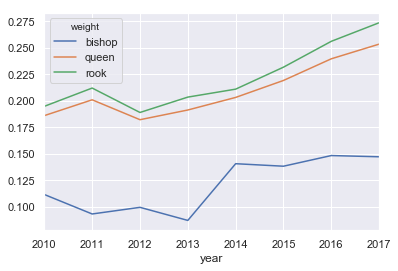

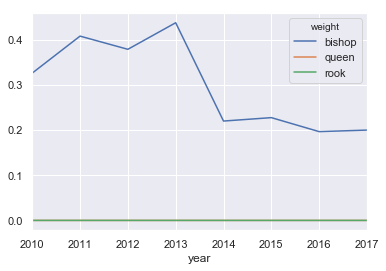

In [21]:
## use only rooks or queen's distance
pd.pivot_table(morans_data, values='moran_i', columns='weight', index='year').plot()
pd.pivot_table(morans_data, values='moran_p', columns='weight', index='year').plot()

In [22]:
model, y_preds_spatial, y_true_spatial = spatial_model(yearly_data, 2016, x_cols, y_col = 'log_rate', weight='rook')
print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :  censusdata
Weights matrix      :     unknown
Dependent Variable  :    log_rate                Number of Observations:         195
Mean dependent var  :     -2.0447                Number of Variables   :          13
S.D. dependent var  :      0.9413                Degrees of Freedom    :         182
R-squared           :      0.6060
Adjusted R-squared  :      0.5800
Sum squared residual:      67.736                F-statistic           :     23.3248
Sigma-square        :       0.372                Prob(F-statistic)     :    8.07e-31
S.E. of regression  :       0.610                Log likelihood        :    -173.598
Sigma-square ML     :       0.347                Akaike info criterion :     373.197
S.E of regression ML:      0.5894                Schwarz criterion     :     415.746

-----------------------------------------------------------------------------

Residual distribution:
 DescribeResult(nobs=195, minmax=(-5.105058284927712, 3.797110645675083), mean=0.06682302038802025, variance=1.269085173610321, skewness=-0.5573337979169098, kurtosis=2.7340298681716053)

MSE: 1.2670423605686612


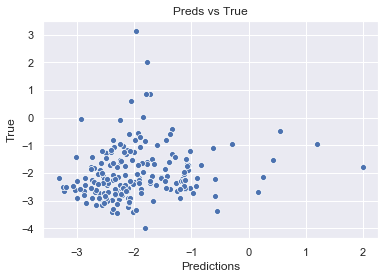

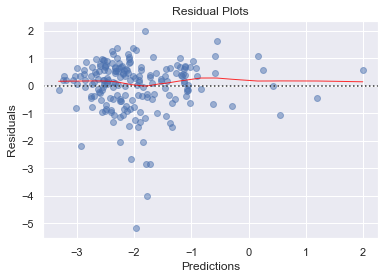

In [23]:
y_preds_spatial2 = [v[0] for v in y_preds_spatial]
analyze_preds_true(y_preds_spatial2, y_test)  # for model